## Dengue Prediction with Gradient Boosting
#### Import packages & data

In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.datasets import make_classification

import matplotlib.pyplot as plt
import seaborn as sns

import shap
from shap import TreeExplainer, summary_plot, dependence_plot

import imblearn 
from imblearn.over_sampling import SMOTE, ADASYN

from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold, cross_validate

import xgboost as xgb
from xgboost import XGBClassifier

import lightgbm as lgb


In [2]:
# Read data
df = pd.read_csv('/Users/lorenzoflores/Desktop/Yale_Academic/Stat Projects/Dengue Mapping Project/philhealthSummary.csv')

# Choose features
features = ['Month','Year','NDWI','FAPAR','Pop','Density']
X = df[features]

In [15]:
df['Binary'].value_counts()

1    3608
0    1217
Name: Binary, dtype: int64

In [17]:
df['medRisk'].value_counts()

0    4242
1     583
Name: medRisk, dtype: int64

In [16]:
df['highRisk'].value_counts()

0    4613
1     212
Name: highRisk, dtype: int64

#### Define the models

In [3]:
# define the model
model = GradientBoostingClassifier()

# define parameter space
distributions = dict(learning_rate = list(np.linspace(0.05,0.3,6)), 
                     n_estimators = list(range(1,11)), 
                     min_samples_split = list(range(2,8)))

# define cross validation
cv = KFold(shuffle = True, n_splits = 5)

# instantiate
clf = RandomizedSearchCV(model, distributions, cv=cv)


In [4]:
# define the model
search1_xgb = xgb.XGBClassifier(objective = 'binary:logistic',
                                eval_metric = 'error')

# define parameter space
param_dist = {'eta': list(np.linspace(0.05,0.3,6)), 
              'gamma': list(np.linspace(0,0.5,6))
             }

# define cross validation
cv = KFold(shuffle = True, n_splits = 5)

# instantiate
clf_xgb = RandomizedSearchCV(search1_xgb, param_dist, cv = cv)


In [5]:
# define the model
search1_lgb = lgb.LGBMClassifier(objective = 'binary',
                                eval_metric = 'error')

# define parameter space
param_dist = {'eta': list(np.linspace(0.05,0.3,6)), 
              'gamma': list(np.linspace(0,0.5,6))
             }

# define cross validation
cv = KFold(shuffle = True, n_splits = 5)

# instantiate
clf_lgb = RandomizedSearchCV(search1_lgb, param_dist, cv = cv)


#### Balance the dataset

In [6]:
# balance the dataset
X1, y1 = SMOTE().fit_resample(X, df['medRisk'])

# balance the dataset
X2, y2 = SMOTE().fit_resample(X, df['Binary'])

# balance the dataset
X3, y3 = SMOTE().fit_resample(X, df['highRisk'])


#### Models

In [7]:
print('Medium Risk: 10 cases and above')
# fit
search1 = clf.fit(X, df['medRisk'])
print('Gradient Boost: '+str(search1.best_score_))

# fit XGBoost
search1_xgb = clf_xgb.fit(X, df['medRisk'])
print('XGBoost: '+str(search1_xgb.best_score_))

# fit Light GBM
search1_lgb = clf_lgb.fit(X, df['medRisk'])
print('LGBM: '+str(search1_lgb.best_score_))

Medium Risk: 10 cases and above
Gradient Boost: 0.9266321243523314
XGBoost: 0.9367875647668393
LGBM: 0.934922279792746


In [8]:
print('Binary: 1 case and above')
# fit
search2 = clf.fit(X2, y2)
print('Gradient Boost: '+str(search2.best_score_))

# fit XGBoost
search2_xgb = clf_xgb.fit(X, df['Binary'])
print('XGBoost: '+str(search2_xgb.best_score_))

# fit Light GBM
search2_lgb = clf_lgb.fit(X, df['Binary'])
print('LGBM: '+str(search2_lgb.best_score_))

Binary: 1 case and above
Gradient Boost: 0.7922659394958564
XGBoost: 0.8084974093264249
LGBM: 0.804559585492228


In [9]:
print('High Risk: 20 cases and above')
# fit
search3 = clf.fit(X3, y3)
print('Gradient Boost: '+str(search3.best_score_))

# fit XGBoost
search3_xgb = clf_xgb.fit(X, df['highRisk'])
print('XGBoost: '+str(search3_xgb.best_score_))

# fit Light GBM
search3_lgb = clf_lgb.fit(X, df['highRisk'])
print('LGBM: '+str(search3_lgb.best_score_))

High Risk: 20 cases and above
Gradient Boost: 0.9344244495532712
XGBoost: 0.9732642487046632
LGBM: 0.9747150259067358


#### SHAP values/Feature importances

In [10]:
def plotImp(X, y, model):
    feat = pd.DataFrame({'Feature':list(X.columns),
                          'Importance':model.best_estimator_.feature_importances_})
    feat = feat.sort_values(by='Importance',ascending=False)

    # Plot feature importances
    sns.set_style("whitegrid")
    plt.figure(figsize=(10,3))
    sns.barplot(x='Importance', 
                y='Feature', 
                data=feat,
                color='blue').set_title('Feature Importances')
    plt.show()
    
    print('\n')
    
    # SHAP values
    explainer = TreeExplainer(model.best_estimator_,
                             feature_perturbation = "tree_path_dependent")
    shapval = explainer.shap_values(X, y)
    summary_plot(shapval, X, X.columns)

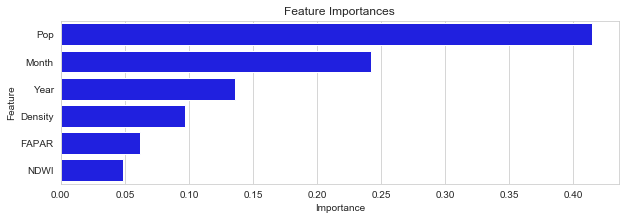

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


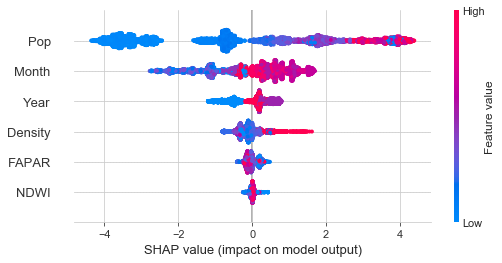

In [11]:
plotImp(X1, y1, search1_xgb)

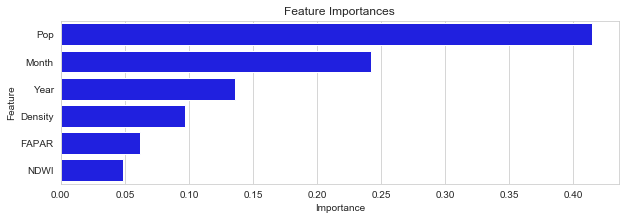

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


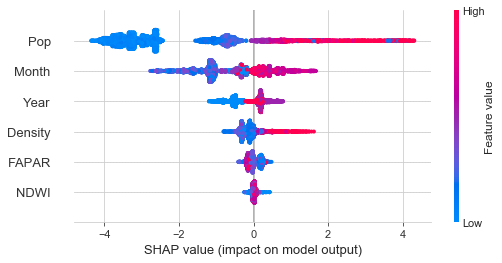

In [12]:
plotImp(X2, y2, search2_xgb)

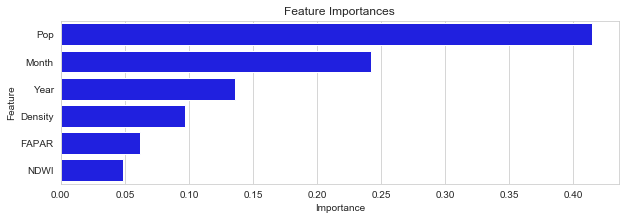

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


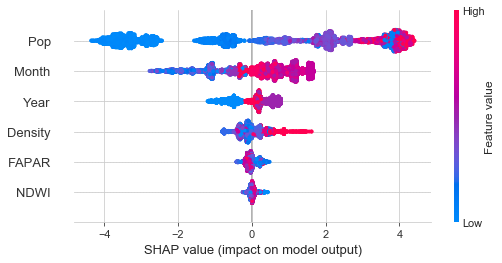

In [13]:
plotImp(X3, y3, search3_xgb)